<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_inv, p):  # S is the matrix such that ||S @ Dx||\leq delta. As a consequence, S_inv appears in the unconstrained problem
        m, n = X.shape
        q = compute_q(p)
        print("who is q ", q)
        # Formulate problem
        param = cp.Variable(n)
        print("shape param ", param.shape)
        print("dim ", n)
        print(S_inv.shape)
        print("S_inv ", S_inv)
        partial = S_inv @ param  # should be (m * n,)
        if S_inv.shape == (n, n):
          print("S_inv (n, n)")
          param_norm = cp.pnorm(partial, p=q)
        else:  # should be a stack of matrix
          print("S_inv conc")
          print("shape partial 1", partial.shape)
          partial = cp.reshape(partial, (m, n), order='C')
          print("shape partial ", partial.shape)
          param_norm = cp.pnorm(partial, p=q, axis=1)
        print("param_norm.shape", param_norm.shape)
        print("param_norm\n", param_norm)
        adv_radius = cp.Parameter(name='adv_radius', nonneg=True)
        print("ciao2")
        abs_error = cp.abs(X @ param - y)
        print("abs_error.shape ", abs_error.shape)
        print("ciao3")
        adv_loss = 1 / m * cp.sum((abs_error + adv_radius * param_norm) ** 2)
        print("ciao4")
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius = adv_radius
        self.param = param
        self.warm_start = False


    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T


def plot_coefs(alphas, coefs, ax):
    print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_inv, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_inv, p=np.inf)
    estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
    alphas_adv, coefs_advtrain_linf  = get_path(X, y, estimator, 1e1)
    plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
    plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return coefs_advtrain_linf


def add_rectangles(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 0.1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)


#def add_rectangles(x, y, box_width, box_height, ax):
#  for xi, yi in zip(x, y):
#      rect = patches.Rectangle(
#        (xi-box_width/2, yi-box_height/2),
#        box_width, box_height,
#        linewidth=1, edgecolor='r', facecolor='none'
#      )
#      ax.add_patch(rect)

print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [7]:
# imputation's block

def clear_dataset(x, masks):
  # remove observations full NaN
  M = np.sum(1 - masks, axis=1) > 0
  return x[M, :], masks[M, :]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res ", res)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [ ]:
# define observations
np.random.seed(45)
n_observationsss = 300
dim = 10
#cov = np.random.randint(low=1, high=10, size=(d, d))
#cov = np.random.randn(d, d)
#cov = cov.T @ cov + np.eye(dim) * 1e-5
#print(cov)
#print(np.linalg.eigvalsh(cov))
cov = np.eye(dim)
X_orig = np.random.rand(n_observationsss, dim) @ cov
#X_orig = np.random.randint(low=1, high=4, size=(n, d)) * 1.0
#X -= X.mean(axis=0)
#X /= X.std(axis=0)
b = np.random.rand(dim)

#L = np.linalg.cholesky(S)  # return L such that S = LL.T
#L_inv = np.linalg.inv(L)
#S_inv = L_inv.T @ L_inv

masks = np.random.binomial(1, 0.25, (n_observationsss, dim))  # 1 missing, 0 seen

X_orig, masks = clear_dataset(X_orig, masks)
n_observationsss = X_orig.shape[0]
print("shape ", X_orig.shape)
print("final shape ", X_orig.shape)
y = X_orig @ b
X_nan = X_orig.copy()
X_nan[masks == 1] = np.nan
print("end block")

shape  (300, 10)
final shape  (300, 10)
end block


In [ ]:
## original lasso
fig, ax = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_orig, y)
plot_coefs_l1norm(coefs_lasso, ax)

In [ ]:
# training with original dataset X_orig
fig, ax = plt.subplots(num='advtrain_linf')
sd_orig = np.std(X_orig, axis=0)
print("sd_orig \n", sd_orig)
S_inv_orig = np.diag(1 / sd_orig)
#S_inv_orig = np.eye(dim)
S_inv_orig = np.array([S_inv_orig] * n_observationsss)
S_inv_orig = np.concatenate(S_inv_orig)
print("S_inv_orig.shape ", S_inv_orig.shape)
test = S_inv_orig @ np.arange(dim)
#print("test mult\n", test)
#print("test reshape \n", test.reshape(n_observationsss, dim, order='C'))
#print(S_inv_orig)
#S_inv_orig = np.diag(1 / sd_orig)
#print("S_inv_orig shape\n ", S_inv_orig.shape)
#S_inv_orig = np.eye(X_orig.shape[0])
linfadvtrain = AdversarialTraining(X_orig, y, S_inv_orig, p=np.inf)
estimator = lambda X, y, a:  linfadvtrain(adv_radius=a)
alphas_adv, coefs_advtrain_linf  = get_path(X_orig, y, estimator, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf, ax)
#plot_coefs(alphas_adv, coefs_advtrain_linf, ax)

In [8]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    # p_missing = [0.3, 0.3, 0.4]
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  print("shape X ", X.shape)
  print("shape coeff ", coeff.shape)
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  print("shape y ", y.shape)
  print("size haty ", hat_y.shape)
  r = hat_y - y  # residual
  print("size r ", r.shape)
  score = np.mean(r * r, axis=1)
  print("size score ", score.size)
  i_min = np.argmin(score)
  print("i_min ", i_min)
  print("best predictor, coeff i_min ")
  return coeff[:, i_min], score[i_min]


def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


def experiment_2d(n_tot, perc_test, p_miss, beta_gt, ax):

    #fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf_2d')
    X_complete = np.random.randn(n_tot, beta_gt.size)
    y_complete = X_complete @ beta_gt + np.random.randn(n_tot) * 1e-1
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)

    n_train, n_test = X_train.shape[0], X_test.shape[0]
    mask = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component
    print(M.size)
    print("nbr components without missing entries ", np.sum(1-M))
    #print("print M, M[i] == 1 iff one component is missing", M)

    X_masked = X_train * (1 - mask)

    X_nan_train = X_train.copy()
    X_nan_train[mask == 1] = np.nan

    X_br_train = single_imputation(X_nan_train, BayesianRidge())
    sd = np.std(X_br_train, axis=0)
    print("shape X_bri Train ", X_br_train.shape)
    print("sd deviation columnwise: ", sd)

    S_inv = np.diag(1 / sd) * 1
    plt.tight_layout()
    #print(X_br_train[M == 0, 0])
    ax[0].scatter(X_br_train[M == 0, 0], X_br_train[M == 0, 1])
    ax[0].scatter(X_br_train[M == 1, 0], X_br_train[M == 1, 1])
    add_rectangles(X_br_train[:, 0], X_br_train[:, 1], S_inv[0, 0], S_inv[1, 1], ax[0])

    coeff_res = train_and_plot(X_br_train, y_train, S_inv, [ax[1], ax[2]])
    print("shape coeff ", coeff_res.shape)
    best_coeff, min_score = best_predictor(X_test, coeff_res, y_test)
    print("best coeff ", best_coeff)
    print("min score ", min_score)
    #plt.show()
    return best_coeff, min_score


[-0.5  2. ]
iteration  0
80
nbr components without missing entries  39.0
shape X_bri Train  (80, 2)
sd deviation columnwise:  [1.02555531 0.79745741]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[0.97508149 0.        ]
 [0.         1.25398546]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[0.98 0.00]
 [0.00 1.25]] @ var1)
ciao2
abs_error.shape  (80,)
ciao3
ciao4


100%|██████████| 200/200 [00:01<00:00, 134.88it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (20, 2)
shape coeff  (2, 200)
shape y  (20,)
size haty  (200, 20)
size r  (200, 20)
size score  200
i_min  99
best predictor, coeff i_min 
best coeff  [-0.09155106  1.88684522]
min score  0.2516462547093515
best coeff  [-0.09155106  1.88684522]
min score  0.2516462547093515
iteration  1
400
nbr components without missing entries  256.0
shape X_bri Train  (400, 2)
sd deviation columnwise:  [0.8718476  0.91574665]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.14698945 0.        ]
 [0.         1.09200509]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.15 0.00]
 [0.00 1.09]] @ var68)
ciao2
abs_error.shape  (400,)
ciao3
ciao4


100%|██████████| 200/200 [00:03<00:00, 56.10it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (100, 2)
shape coeff  (2, 200)
shape y  (100,)
size haty  (200, 100)
size r  (200, 100)
size score  200
i_min  104
best predictor, coeff i_min 
best coeff  [-0.43158864  1.98068353]
min score  0.01344788579651536
best coeff  [-0.43158864  1.98068353]
min score  0.01344788579651536
iteration  2
600
nbr components without missing entries  364.0
shape X_bri Train  (600, 2)
sd deviation columnwise:  [0.84302387 0.84175774]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.18620604 0.        ]
 [0.         1.18799027]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.19 0.00]
 [0.00 1.19]] @ var135)
ciao2
abs_error.shape  (600,)
ciao3
ciao4


100%|██████████| 200/200 [00:04<00:00, 44.55it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (150, 2)
shape coeff  (2, 200)
shape y  (150,)
size haty  (200, 150)
size r  (200, 150)
size score  200
i_min  100
best predictor, coeff i_min 
best coeff  [-0.43578967  1.9771566 ]
min score  0.018515587092523135
best coeff  [-0.43578967  1.9771566 ]
min score  0.018515587092523135
final coeff 
 [[-0.09155106 -0.43158864 -0.43578967]
 [ 1.88684522  1.98068353  1.9771566 ]]
final scores 
  [0.25164625 0.01344789 0.01851559]


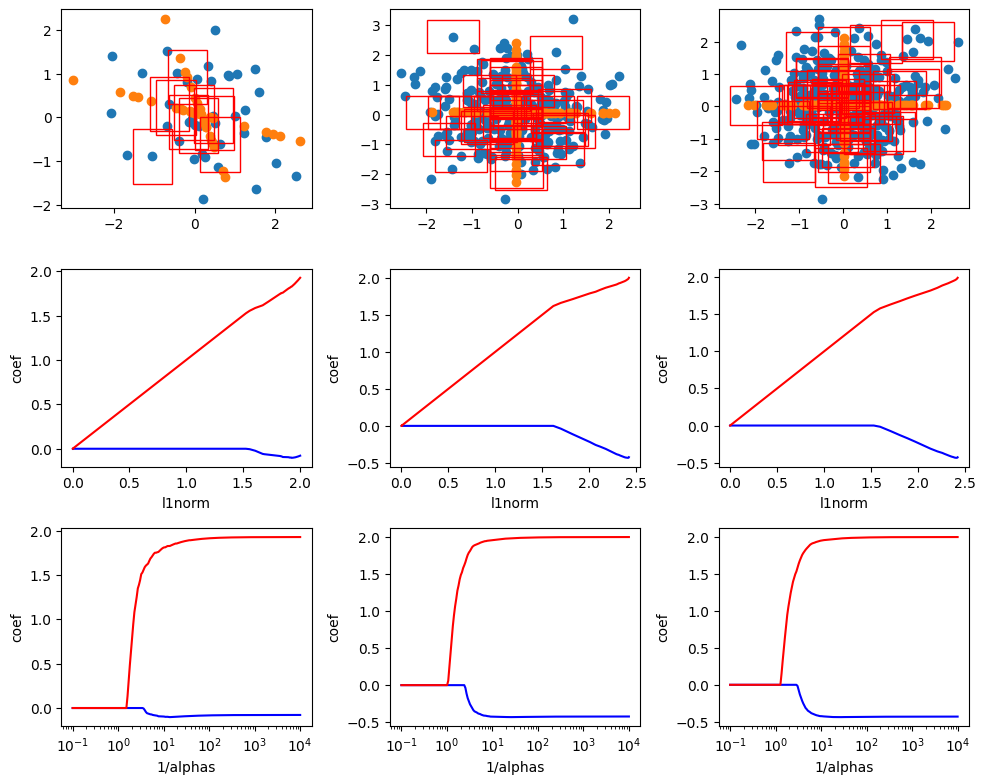

In [ ]:
np.random.seed(43)
list_tot = [100, 500, 750]
l = len(list_tot)
p_miss_2d = [0.6, 0.2, 0.2]
#beta_2d = np.random.randn(2)
beta_2d = np.array([-0.5, 2])
print(beta_2d)
scores_fin = np.zeros(l)
coeff_fin = np.zeros((2, l))

fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')

for i in range(l):
    print("iteration ", i)
    n_tot = list_tot[i]
    best_coeff_round, min_score_round = experiment_2d(n_tot, 0.2, p_miss_2d, beta_2d, ax[:, i])
    print("best coeff ", best_coeff_round)
    print("min score ", min_score_round)
    coeff_fin[:, i] = best_coeff_round
    scores_fin[i] = min_score_round
print("final coeff \n", coeff_fin)
print("final scores \n ", scores_fin)



In [ ]:
np.random.seed(43)
list_tot = [750, 1000, 2000]  # 750, 1000, 2000
l = len(list_tot)
p_miss_2d = [0.1, 0.45, 0.45]  # 0.1, 0.45, 0.45
#beta_2d = np.random.randn(2)
beta_2d = np.array([-0.5, 2])
print("ground truth ", beta_2d)
scores_fin = np.zeros(l)
coeff_fin = np.zeros((2, l))
scores_fin_ld = np.zeros(l)
coeff_fin_ld = np.zeros((2, l))

p_test = 0.2  # 0.2
err_2d = 2.5  # 5
fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')
fig1, ax1 = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d1')


for i in range(l):
    print("--------> iteration ", i)
    n_total = list_tot[i]
    dict_obser = generate_dataset(data='Gaussian', n_tot=n_total, dim=2, beta_gt=beta_2d, perc_test=p_test, p_miss=p_miss_2d, err=err_2d)
    best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, ax[:, i])
    print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
    coeff_fin[:, i] = best_coeff_round
    scores_fin[i] = min_score_round
    #print(dict_obser)
    # deep_copied = copy.deepcopy(original)
    dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
    dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
    dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
    #print(dict_obser)
    best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, ax1[:, i])
    coeff_fin_ld[:, i] = best_coeff_round_ld
    scores_fin_ld[i] = min_score_round_ld

print("final coeff \n", coeff_fin.T)
print("final scores \n ", scores_fin)

print("final coeff \n", coeff_fin_ld.T)
print("final scores \n ", scores_fin_ld)

##  bayesian imputation + robust opt vs listwise delection



In [33]:
# experiment 2d with dataset generated externally

def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    if data == 'Gaussian':
      X_complete = np.random.randn(n_tot, beta_gt.size)
    elif data == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['kind'] == 'Gaussian':
      print("--------------------------------------> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['kind'] == 'Uniform':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, ax):
    #fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf_2d')
    #X_complete = np.random.randn(n_tot, beta_gt.size)
    #y_complete = X_complete @ beta_gt + np.random.randn(n_tot) * 1e-1
    X_train = dict_obs['X_train']
    X_test = dict_obs['X_test']
    y_train = dict_obs['y_train']
    y_test = dict_obs['y_test']
    mask = dict_obs['masks_train']
    #X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)

    n_train, n_test = X_train.shape[0], X_test.shape[0]
    print("-------> size train: ", n_train, " size test: ", n_test)
    #mask = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component
    #print(M.size)
    print("nbr components without missing entries ", np.sum(1-M))
    #print("print M, M[i] == 1 iff one component is missing", M)

    X_masked = X_train * (1 - mask)

    X_nan_train = X_train.copy()
    X_nan_train[mask == 1] = np.nan

    X_br_train = single_imputation(X_nan_train, BayesianRidge())
    sd = np.std(X_br_train, axis=0)
    print("shape X_bri Train ", X_br_train.shape)
    print("sd deviation columnwise:------------>", sd)

    S_inv = np.diag(1 / sd)
    plt.tight_layout()
    #print(X_br_train[M == 0, 0])
    ax[0].scatter(X_br_train[M == 0, 0], X_br_train[M == 0, 1])
    ax[0].scatter(X_br_train[M == 1, 0], X_br_train[M == 1, 1])
    add_rectangles(X_br_train[:, 0], X_br_train[:, 1], S_inv[0, 0], S_inv[1, 1], ax[0])

    coeff_res = train_and_plot(X_br_train, y_train, S_inv, [ax[1], ax[2]])
    print("shape coeff ", coeff_res.shape)
    best_coeff, min_score = best_predictor(X_test, coeff_res, y_test)
    print("best coeff ", best_coeff)
    print("min score ", min_score)
    #plt.show()
    return best_coeff, min_score


In [24]:

def run_experiments(dictio, methods):
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
    l = len(dictio['data'])
    scores_fin = np.zeros(l)
    coeff_fin = np.zeros((2, l))
    scores_fin_ld = np.zeros(l)
    coeff_fin_ld = np.zeros((2, l))
    fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d')
    if 'listwise_deletion' in methods:
      fig_ld, ax_ld = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_ld')

    for i in range(l):
      print("--------> iteration ", i)
      dict_obser = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, ax[:, i])
      print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
      coeff_fin[:, i] = best_coeff_round
      scores_fin[i] = min_score_round
      # print(dict_obser)
      # deep_copied = copy.deepcopy(original)
      if 'listwise_deletion' in methods:
        dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
        dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
        dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
        #print(dict_obser)
        best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, ax_ld[:, i])
        coeff_fin_ld[:, i] = best_coeff_round_ld
        scores_fin_ld[i] = min_score_round_ld


    print("final coeff \n", coeff_fin.T)
    print("final scores \n ", scores_fin)
    if 'listwise_deletion' in methods:
      print("----> listwise del: ", "final coeff_ld\n", coeff_fin_ld.T, "\n final score_ld ", scores_fin_ld)




{'data': ['moons', 'moons', 'moons'], 'n_tot': [100, 250, 500], 'dim': [2, 2, 2], 'beta_gt': [array([-0.5,  2. ]), array([-0.5,  2. ]), array([-0.5,  2. ])], 'perc_test': [0.2, 0.2, 0.2], 'p_miss': [[0.8, 0.1, 0.1], [0.8, 0.1, 0.1], [0.8, 0.1, 0.1]], 'err': [{'kind': 'Gaussian', 'scaling': 2}, {'kind': 'Gaussian', 'scaling': 2}, {'kind': 'Gaussian', 'scaling': 2}]}
--------> iteration  0
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
-------> size train:  80  size test:  20
nbr components without missing entries  66.0
shape X_bri Train  (80, 2)
sd deviation columnwise:------------> [0.81703861 0.47639294]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.22393237 0.        ]
 [0.         2.09910752]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.22 0.00]
 [0.00 2.10]] @ var5227)
ciao2
abs_error.shape  (80,)
ciao3
ciao4


100%|██████████| 200/200 [00:01<00:00, 182.28it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (20, 2)
shape coeff  (2, 200)
shape y  (20,)
size haty  (200, 20)
size r  (200, 20)
size score  200
i_min  0
best predictor, coeff i_min 
best coeff  [-0.51002759  2.57712787]
min score  3.826620093519675
best coeff  [-0.51002759  2.57712787] 
 min score  3.826620093519675
-------> size train:  66  size test:  20
nbr components without missing entries  66.0
shape X_bri Train  (66, 2)
sd deviation columnwise:------------> [0.85406255 0.50411901]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.17087443 0.        ]
 [0.         1.98365857]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.17 0.00]
 [0.00 1.98]] @ var5294)
ciao2
abs_error.shape  (66,)
ciao3
ciao4


100%|██████████| 200/200 [00:00<00:00, 246.38it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (20, 2)
shape coeff  (2, 200)
shape y  (20,)
size haty  (200, 20)
size r  (200, 20)
size score  200
i_min  0
best predictor, coeff i_min 
best coeff  [-0.64910186  2.62681481]
min score  3.7549018774087557
--------> iteration  1
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
-------> size train:  200  size test:  50
nbr components without missing entries  172.0
shape X_bri Train  (200, 2)
sd deviation columnwise:------------> [0.86671905 0.48901592]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.15377641 0.        ]
 [0.         2.0449232 ]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.15 0.00]
 [0.00 2.04]] @ var5361)
ciao2
abs_error.shape  (200,)
ciao3
ciao4


100%|██████████| 200/200 [00:01<00:00, 106.62it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (50, 2)
shape coeff  (2, 200)
shape y  (50,)
size haty  (200, 50)
size r  (200, 50)
size score  200
i_min  85
best predictor, coeff i_min 
best coeff  [-0.52533874  1.52415889]
min score  4.59247645019932
best coeff  [-0.52533874  1.52415889] 
 min score  4.59247645019932
-------> size train:  172  size test:  50
nbr components without missing entries  172.0
shape X_bri Train  (172, 2)
sd deviation columnwise:------------> [0.87944573 0.50198456]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.13707983 0.        ]
 [0.         1.99209313]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.14 0.00]
 [0.00 1.99]] @ var5428)
ciao2
abs_error.shape  (172,)
ciao3
ciao4


100%|██████████| 200/200 [00:01<00:00, 123.34it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (50, 2)
shape coeff  (2, 200)
shape y  (50,)
size haty  (200, 50)
size r  (200, 50)
size score  200
i_min  65
best predictor, coeff i_min 
best coeff  [-0.53065021  1.51778475]
min score  4.592731455436484
--------> iteration  2
--------------------------------------> you have entered in GAUSSIAN ERROR  scaling :  2
-------> size train:  400  size test:  100
nbr components without missing entries  320.0
shape X_bri Train  (400, 2)
sd deviation columnwise:------------> [0.85835435 0.50068481]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.16502002 0.        ]
 [0.         1.99726452]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.17 0.00]
 [0.00 2.00]] @ var5495)
ciao2
abs_error.shape  (400,)
ciao3
ciao4


100%|██████████| 200/200 [00:02<00:00, 73.09it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (100, 2)
shape coeff  (2, 200)
shape y  (100,)
size haty  (200, 100)
size r  (200, 100)
size score  200
i_min  83
best predictor, coeff i_min 
best coeff  [-0.46279292  2.18214618]
min score  4.1844034334489315
best coeff  [-0.46279292  2.18214618] 
 min score  4.1844034334489315
-------> size train:  320  size test:  100
nbr components without missing entries  320.0
shape X_bri Train  (320, 2)
sd deviation columnwise:------------> [0.89231868 0.52039851]
who is q  1
shape param  (2,)
dim  2
(2, 2)
S_inv  [[1.12067585 0.        ]
 [0.         1.92160427]]
S_inv (n, n)
param_norm.shape ()
param_norm
 norm1([[1.12 0.00]
 [0.00 1.92]] @ var5562)
ciao2
abs_error.shape  (320,)
ciao3
ciao4


100%|██████████| 200/200 [00:03<00:00, 61.62it/s]


you are printing coeff in function of l1 norm
you are printing coefs in function of 1/alphas
shape coeff  (2, 200)
shape X  (100, 2)
shape coeff  (2, 200)
shape y  (100,)
size haty  (200, 100)
size r  (200, 100)
size score  200
i_min  87
best predictor, coeff i_min 
best coeff  [-0.44791467  2.18052856]
min score  4.175825851308989
final coeff 
 [[-0.51002759  2.57712787]
 [-0.52533874  1.52415889]
 [-0.46279292  2.18214618]]
final scores 
  [3.82662009 4.59247645 4.18440343]
----> listwise del:  final coeff_ld
 [[-0.64910186  2.62681481]
 [-0.53065021  1.51778475]
 [-0.44791467  2.18052856]] 
 final score_ld  [3.75490188 4.59273146 4.17582585]


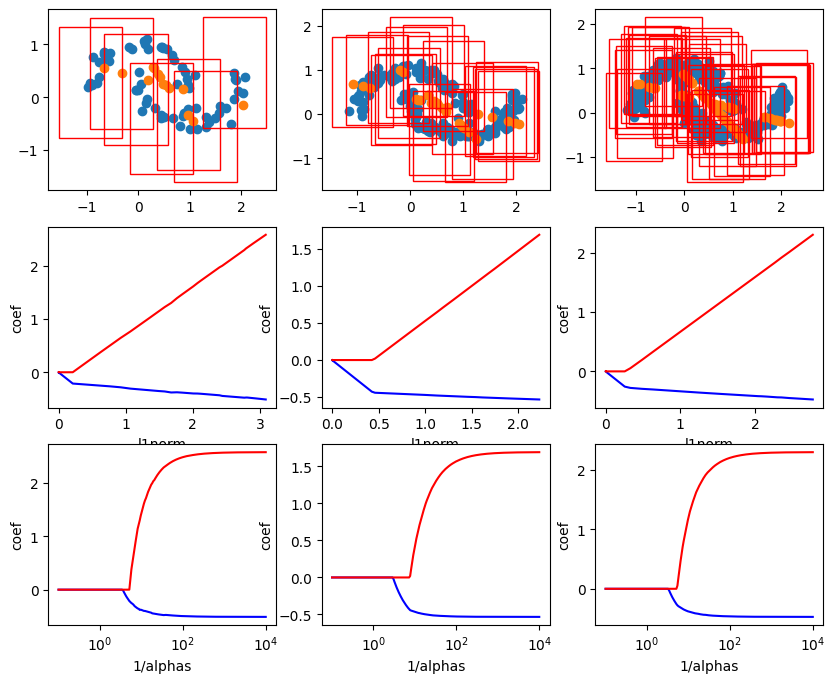

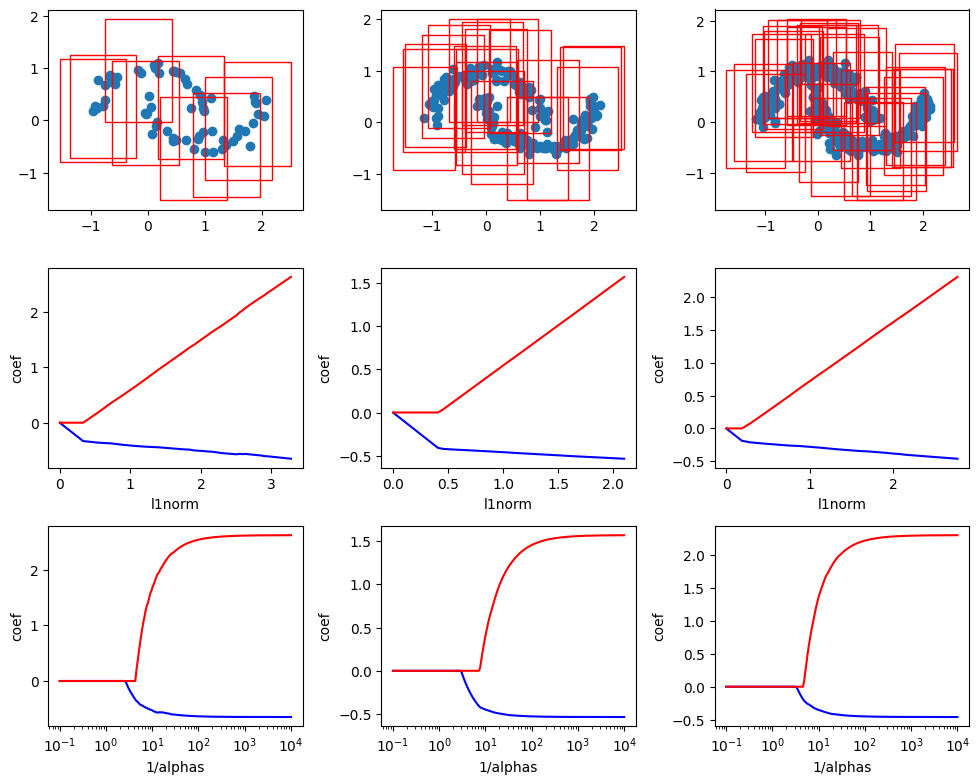

In [32]:
np.random.seed(47)  # 43
n_tot = [100, 250, 500]  # 750, 1000, 2000
ll = len(n_tot)
data = ['moons'] * ll
#n_tot = [75, 100, 200]
dim = [2] * ll
beta_gt = [np.array([-0.5, 2])] * ll
perc_test = [0.2] * ll
p_miss = [[0.8, 0.1, 0.1]] * ll
err_dic = {'kind': 'Gaussian', 'scaling': 2}
err = [err_dic] * ll
dicc = {'data':data,
        'n_tot': n_tot,
        'dim': dim,
        'beta_gt': beta_gt,
        'perc_test': perc_test,
        'p_miss': p_miss,
        'err': err}

print(dicc)

run_experiments(dicc, ['listwise_deletion'])


In [ ]:
np.random.seed(43)
list_tot = [750, 1000, 2000]  # 750, 1000, 2000
l = len(list_tot)
p_miss_2d = [0.1, 0.45, 0.45]  # 0.1, 0.45, 0.45
beta_2d = np.array([-0.5, 2])
print("ground truth ", beta_2d)
scores_fin = np.zeros(l)
coeff_fin = np.zeros((2, l))
scores_fin_ld = np.zeros(l)
coeff_fin_ld = np.zeros((2, l))

p_test = 0.2  # 0.2
err_2d = 2.5  # 5
fig, ax = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_mi')
fig1, ax1 = plt.subplots(3, l, figsize=(10, 8), num='advtrain_linf_2d_mi1')

# test with imputation by multiple imputation

number_multiple_imputed_datasets = 1


for i in range(l):
    print("--------> iteration ", i)
    n_total = list_tot[i]
    dict_obser = generate_dataset(data='Gaussian', n_tot=n_total, dim=2, beta_gt=beta_2d, perc_test=p_test, p_miss=p_miss_2d, err=err_2d)
    best_coeff_round, min_score_round = experiment_2d_ext_dataset(dict_obser, ax[:, i])
    print("best coeff ", best_coeff_round, "\n min score ", min_score_round)
    coeff_fin[:, i] = best_coeff_round
    scores_fin[i] = min_score_round
    #print(dict_obser)
    # deep_copied = copy.deepcopy(original)
    dict_obser['X_train'] = listwise_delection(dict_obser['X_train'], dict_obser['masks_train'])
    dict_obser['y_train'] = listwise_delection(dict_obser['y_train'], dict_obser['masks_train'])
    dict_obser['masks_train'] = np.zeros_like(dict_obser['X_train'])
    #print(dict_obser)
    best_coeff_round_ld, min_score_round_ld = experiment_2d_ext_dataset(dict_obser, ax1[:, i])
    coeff_fin_ld[:, i] = best_coeff_round_ld
    scores_fin_ld[i] = min_score_round_ld

print("final coeff \n", coeff_fin.T)
print("final scores \n ", scores_fin)

print("final coeff \n", coeff_fin_ld.T)
print("final scores \n ", scores_fin_ld)





X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)










In [ ]:
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)


In [ ]:
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)

In [ ]:
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)


In [ ]:
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_inv_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)


In [7]:
# mi bayesian ridge

number_multiple_imputed_datasets = 1
X_mi = np.vstack(multiple_imputation(number_multiple_imputed_datasets, X_nan))
sd_mi = np.std(X_mi, axis=0)
print("std_orig: \n", np.std(X_orig, axis=0))
print("sd_mi\n ", sd_mi)
S_inv_mi = np.diag(1 / sd_mi)
yy = np.concatenate([y] * number_multiple_imputed_datasets)

fig, ax = plt.subplots(num='advtrain_linf_mi')
linfadvtrain_mi = AdversarialTraining(X_mi, yy, S_inv_mi, p=np.inf)
estimator_mi = lambda X, y, a:  linfadvtrain_mi(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mi  = get_path(X_mi, yy, estimator_mi, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mi, ax)





NameError: name 'X_nan' is not defined

In [ ]:
Observations:

-) If the data are np.random.randn(), all the graphs looks similar
-) very caotic results if we multiply by a cov matrix


end block


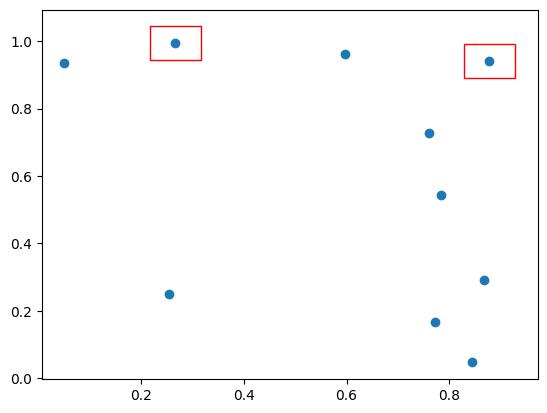

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


[2 1 9 2 8 9 4 8 9 5]
2
[[2 1 9 2 8]
 [9 4 8 9 5]]
10
4.0
4.0
[1 0 1 1 0 0 1 0 1 0]
mm
  (array([[ 1.72083439, -0.0908867 ],
       [ 1.92068747,  0.60608137],
       [ 0.87116014,  0.64154888],
       [-0.57016801,  0.53104892],
       [-0.96103996, -0.12285985],
       [ 0.09425685,  1.0860456 ],
       [ 0.50063122, -0.06497848],
       [ 0.98342288, -0.60817475],
       [ 1.05656871, -0.00607314],
       [ 0.1551155 ,  0.28336192]]), array([1, 1, 0, 0, 0, 0, 1, 1, 0, 1]))


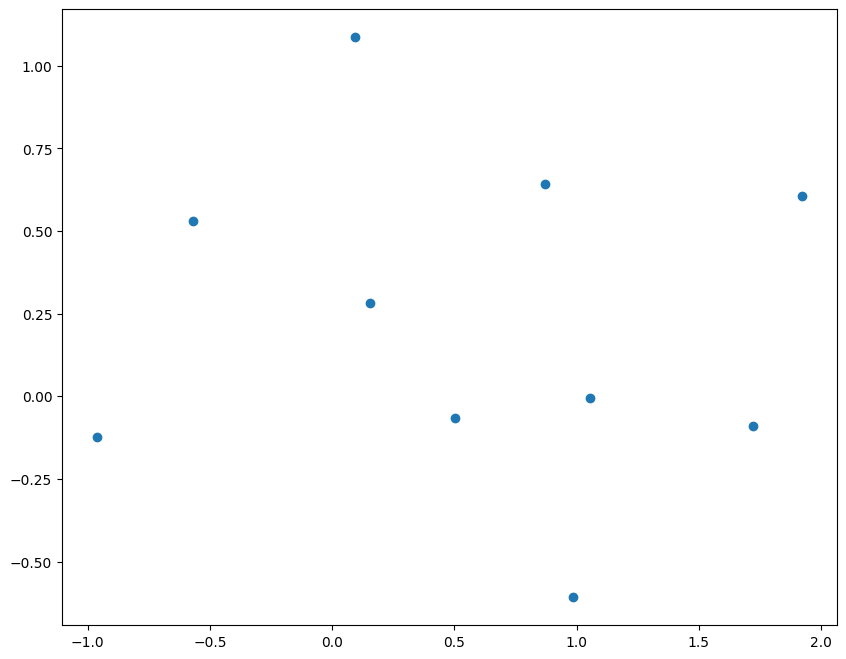

In [ ]:
from sklearn.datasets import make_moons

figt, axt = plt.subplots(1, 1, figsize=(10, 8), num='advtrain_linf_2d')

x = np.random.randint(1, 10, size=10)
print(x)
xx = np.reshape(x, (2, 5), order='C')
print(xx.shape[0])
print(np.reshape(x, (2, 5), order='C'))
print(x.size)
print(np.floor(5 * 0.8))
print(np.floor(5 * 0.8))

bb = np.random.binomial(1, 0.5, size=10)
print(bb)
mm = make_moons(10, noise=0.1)
print("mm\n ", mm)
axt.scatter(mm[0][:, 0], mm[0][:, 1])


test generate_X started
(1000, 2)
test generate passed syccessfully

test preparation dataset started
X_train 
 [[0.69368108 0.6776661  0.29958156 0.86900122]
 [0.2625603  0.1225604  0.15102284 0.18246493]
 [0.80086953 0.72829399 0.32207279 0.88681909]]
mask, 0 seen, 1 missing 
  [[0 1 1 1]
 [1 0 0 0]
 [0 0 1 0]]
X_masked 
 [[0.69368108 0.         0.         0.        ]
 [0.         0.1225604  0.15102284 0.18246493]
 [0.80086953 0.72829399 0.         0.88681909]]
X_nan_train 
 [[0.69368108        nan        nan        nan]
 [       nan 0.1225604  0.15102284 0.18246493]
 [0.80086953 0.72829399        nan 0.88681909]]
X_br_train
  [[0.69368108 0.42540602 0.15102284 0.53460843]
 [0.58655662 0.1225604  0.15102284 0.18246493]
 [0.80086953 0.72829399 0.15102284 0.88681909]]
what happens if we run single_imputation of full dataset
X_br_full
  [[0.69368108 0.6776661  0.29958156 0.86900122]
 [0.2625603  0.1225604  0.15102284 0.18246493]
 [0.80086953 0.72829399 0.32207279 0.88681909]]
test prepa

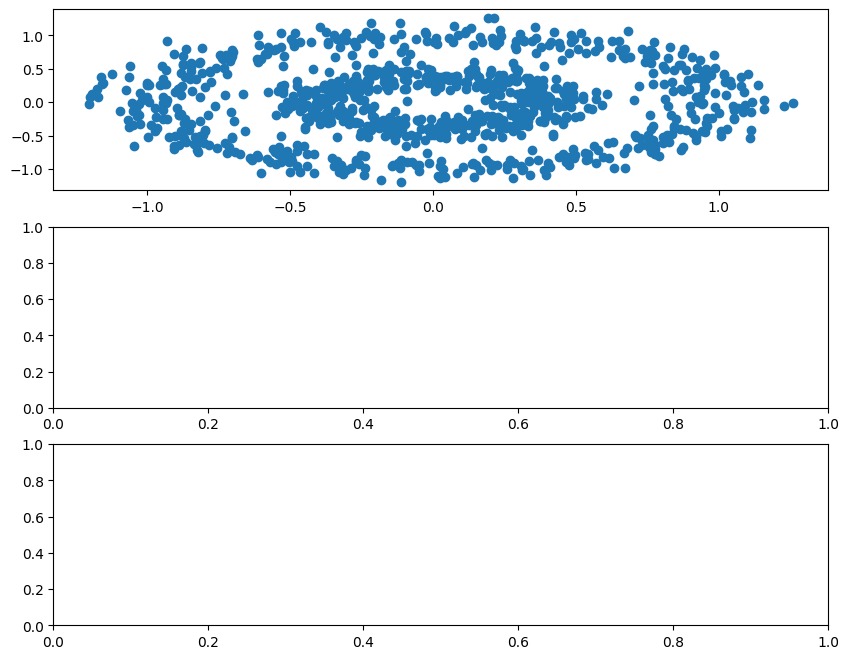

In [ ]:
def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)

    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)


